## TD Test

In [1]:
import pandas as pd
import glob
import os
! pip install visualkeras
import sys
import visualkeras
! pip install pmcx
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import os
import pickle
import numpy as np
from pathlib import Path
import os, re
import joblib
from sklearn.preprocessing import StandardScaler
from google.colab import drive
drive.mount('/content/drive')
folder_path = '/content/drive/MyDrive/MCX_data'
sys.path.append(folder_path)
from FD_msNIRS_2layers import extract_freq as ef
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from typing import Dict, Tuple
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from typing import Sequence, Tuple

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 997.4/997.4 kB 54.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 89.6 MB/s eta 0:00:00
Mounted at /content/drive


In [2]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Conv2D, BatchNormalization, Activation, Add,
    MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout
)
from pathlib import Path
import joblib, tensorflow as tf

In [3]:
SAVE_DIR = Path("/content/drive/MyDrive/MCX_data/splits")
data    = np.load(SAVE_DIR / "train_test_split.npz", allow_pickle=False)
X_test  = data["X_test"]

In [4]:
print(X_test.shape)

(1000, 64, 1000)


In [5]:
param_ranges = {
    "HBO1":  (5.0, 20.0),       # µM
    "HHB1":  (2.5, 12.5),       # µM
    "HBO2":  (25.0, 55.0),      # µM
    "HHB2":  (15.0, 35.0),      # µM
    'd1': (10, 20)
}

In [6]:
def regression_metrics(
    y_true: np.ndarray,
    y_pred: np.ndarray,
    label: str = "",
    verbose: bool = True
) -> Dict[str, float]:

    # 1. sanity check
    y_true = np.asarray(y_true).ravel()
    y_pred = np.asarray(y_pred).ravel()
    if y_true.shape != y_pred.shape:
        raise ValueError("y_true and y_pred must have the same shape")

    # 2. compute metrics
    mae  = mean_absolute_error(y_true, y_pred)
    mare = np.mean(np.abs((y_true - y_pred) / y_true)) * 100.0  # %
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2   = r2_score(y_true, y_pred)
    resid = y_pred - y_true
    bias = resid.mean()
    sd   = resid.std(ddof=1)

    metrics = {
        "MAE": mae,
        "MARE (%)": mare,
        "RMSE": rmse,
        "R2": r2,
        "Bias": bias,
        "SD": sd,
    }

    # 3. optional print
    if verbose:
        name = f"{label} " if label else ""
        n = len(y_true)
        print(f"{name}metrics on test set (n = {n}):")
        print(f"  MAE        : {mae: .4f}")
        print(f"  MARE       : {mare: .2f} %")
        print(f"  RMSE       : {rmse: .4f}")
        print(f"  R²         : {r2: .4f}")
        print(f"  Bias ± SD  : {bias: .4f} ± {sd: .4f}")

    return metrics


In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

def plot_pred_vs_true(
    y_true: np.ndarray,
    y_pred: np.ndarray,
    x_label: str = r"$\mathrm{Ground\ truth}$",
    y_label: str = r"$\mathrm{Predicted}$",
    ax: plt.Axes | None = None,
    figsize: tuple[int, int] = (12, 12),
    dpi: int = 150,
    ms: int = 25,
    color: str = "#1f77b4",
    metrics_color: str = "firebrick",
    show_grid: bool = True,
):
    """
    Publication-friendly scatter plot with MSE & MARE annotation.
    All font sizes are large for visibility in slides/posters.
    """
    # ---------- checks -------------------------------------------------
    y_true = np.asarray(y_true).ravel()
    y_pred = np.asarray(y_pred).ravel()
    if y_true.shape != y_pred.shape:
        raise ValueError("y_true and y_pred must have the same shape")

    # ---------- metrics ------------------------------------------------
    mse  = mean_squared_error(y_true, y_pred)
    mare = np.mean(np.abs((y_true - y_pred) / y_true)) * 100.0  # %

    # ---------- axes ---------------------------------------------------
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize, dpi=dpi)
    else:
        fig = ax.figure

    # ---------- scatter + identity line -------------------------------
    ax.scatter(y_true, y_pred, s=ms, alpha=0.7, color=color)

    lims = [min(y_true.min(), y_pred.min()),
            max(y_true.max(), y_pred.max())]
    ax.plot(lims, lims, "k--", linewidth=1.2)
    ax.set_xlim(lims)
    ax.set_ylim(lims)

    # ---------- labels + tick fonts -----------------------------------
    ax.set_xlabel(x_label, fontsize=20)
    ax.set_ylabel(y_label, fontsize=20)
    ax.tick_params(axis="both", labelsize=18)

    if show_grid:
        ax.grid(which="both", linestyle=":", linewidth=0.7, alpha=0.7)

    # ---------- metrics box -------------------------------------------
    ax.text(
        0.02, 0.98,
        rf"$\mathrm{{MSE}} = {mse:.2e}$" + "\n" +
        rf"$\mathrm{{MARE}} = {mare:.2f}\,\%$",
        transform=ax.transAxes,
        fontsize=16, fontweight="bold",
        va="top", ha="left", color=metrics_color,
    )

    fig.tight_layout()
    return ax


In [60]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from typing import Sequence, Tuple

# ────────────────────────── row-1: scatter ─────────────────────────
def _scatter_panel(ax, yt, yp, x_lab, y_lab, show_ylabel,
                   color="#1f77b4"):
    mse  = mean_squared_error(yt, yp)
    mare = mean_absolute_percentage_error(yt, yp) * 100

    # ── scatter & 1:1 line ──────────────────────────────────────────
    ax.scatter(yt, yp, s=25, alpha=.7, color=color)
    lims = [min(yt.min(), yp.min()), max(yt.max(), yp.max())]
    ax.plot(lims, lims, "k--", lw=1.2)
    ax.set_xlim(lims); ax.set_ylim(lims)

    # ── labels ─────────────────────────────────────────────────────
    ax.set_xlabel(x_lab, fontsize=18)
    if show_ylabel:
        ax.set_ylabel(y_lab, fontsize=18)
    ax.tick_params(labelsize=14)
    ax.grid(ls=":", lw=.6)

    # ── metrics text *above* the axes box ──────────────────────────
    ax.text(
        0.01, 1.03,                                # just above top-left
        rf"$\mathrm{{MSE}} = {mse:.2e}$" "\n"
        rf"$\mathrm{{MARE}} = {mare:.2f}\,\%$",
        transform=ax.transAxes,
        fontsize=14, fontweight="bold",
        va="bottom", ha="left", color="firebrick",
        clip_on=False                              # keep text visible
    )

# ───────────────────────── row-2: histogram ────────────────────────
def _hist_panel(ax, resid, y_lab, show_ylabel, color="#1f77b4"):
    ax.hist(resid, bins=40, alpha=.7, density=True, color=color)
    kde_x = np.linspace(resid.min(), resid.max(), 400)
    ax.plot(kde_x, stats.gaussian_kde(resid)(kde_x), "k-", lw=1.5)

    ax.set_xlabel(y_lab, fontsize=16)
    if show_ylabel:
        ax.set_ylabel('Density', fontsize=16)

    ax.tick_params(labelsize=14); ax.grid(ls=":", lw=.6)

# ───────────────── row-3: residual vs predicted ────────────────────
# ───────────── row-3  Residual vs Predicted ────────────────────────
def _resid_vs_pred_panel(ax, yp, resid,
                         x_lab,                # NEW
                         y_lab, show_ylabel,
                         color="#1f77b4"):
    ax.scatter(yp, resid, s=20, alpha=.6, color=color)
    ax.axhline(0, color="k", ls="--")
    ax.grid(ls=":", lw=.6)

    ax.set_xlabel(x_lab, fontsize=16)      # parameter-specific label
    if show_ylabel:
        ax.set_ylabel(y_lab, fontsize=16)

    ax.tick_params(labelsize=14)

# ─────────────────── 3 × 4 grid driver function ────────────────────
def plot_3x4_suite(
    y_trues : Sequence[np.ndarray],
    y_preds : Sequence[np.ndarray],
    names   : Sequence[str],               # e.g. [r"\mathrm{HbO}_{1}", …]
    units   : str = r"\mu\mathrm{M}",
    figsize : Tuple[int, int] = (22, 15),
    dpi     : int = 300,
):
    if not (len(y_trues) == len(y_preds) == len(names) == 4):
        raise ValueError("Need exactly 4 parameters to make a 3×4 grid")

    fig, axes = plt.subplots(
        3, 4, figsize=figsize, dpi=dpi,
        gridspec_kw=dict(wspace=0.35, hspace=0.35)
    )

    for col, (yt, yp, nm) in enumerate(zip(y_trues, y_preds, names)):
        resid = yp - yt
        show_y = (col == 0)                       # only first column

        # Row 1
        _scatter_panel(
            axes[0, col], yt, yp,
            x_lab = rf"$\mathrm{{GT}}\ {nm}\,({units})$",
            y_lab = r"$\mathrm{Predicted}\ ({\mu\mathrm{M}})$",
            show_ylabel = show_y
        )

        # Row 2
        _hist_panel(
            axes[1, col], resid,
            y_lab = rf"$|{nm}^{{\mathrm{{pred}}}} - {nm}^{{\mathrm{{GT}}}}|$",
            show_ylabel = show_y
        )

        # Row 3
        _resid_vs_pred_panel(
            axes[2, col], yp, resid,
            x_lab = rf"${nm}^{{\mathrm{{pred}}}}$",          # HbO₁ᵖʳᵉᵈ, …
            y_lab = rf"Residual({units})",
            show_ylabel = show_y
        )

    fig.tight_layout()
    return fig


In [62]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.metrics import (mean_squared_error,
                             mean_absolute_percentage_error)
from typing import Sequence, Tuple


# ────────────────  row-1  scatter  ─────────────────────────────────
def _scatter_panel(ax, yt, yp, x_lab, y_lab, show_ylabel,
                   color="#1f77b4"):
    mse  = mean_squared_error(yt, yp)
    mare = mean_absolute_percentage_error(yt, yp) * 100

    ax.scatter(yt, yp, s=25, alpha=.7, color=color)
    lims = [min(yt.min(), yp.min()), max(yt.max(), yp.max())]
    ax.plot(lims, lims, "k--", lw=1.2)
    ax.set_xlim(lims); ax.set_ylim(lims)

    ax.set_xlabel(x_lab, fontsize=18)
    if show_ylabel:
        ax.set_ylabel(y_lab, fontsize=18)

    ax.tick_params(labelsize=14)
    ax.grid(ls=":", lw=.6)

    # metrics text above axis
    ax.text(0.01, 1.03,
            rf"$\mathrm{{MSE}}={mse:.2e}$" "\n"
            rf"$\mathrm{{MARE}}={mare:.2f}\%$",
            transform=ax.transAxes, va="bottom", ha="left",
            fontsize=14, fontweight="bold",
            color="firebrick", clip_on=False)


# ────────────────  row-2  histogram  ───────────────────────────────
def _hist_panel(ax, resid, x_lab, show_ylabel, color="#1f77b4"):
    ax.hist(resid, bins=40, alpha=.7, density=True, color=color)
    kde_x = np.linspace(resid.min(), resid.max(), 400)
    ax.plot(kde_x, stats.gaussian_kde(resid)(kde_x), "k-", lw=1.5)

    ax.set_xlabel(x_lab, fontsize=16)
    if show_ylabel:
        ax.set_ylabel(r"$Density$", fontsize=16)

    ax.tick_params(labelsize=14)
    ax.grid(ls=":", lw=.6)


# ────────────────  row-3  residual vs predicted  ───────────────────
def _resid_vs_pred_panel(ax, yp, resid,
                         x_lab, y_lab, show_ylabel,
                         color="#1f77b4"):
    ax.scatter(yp, resid, s=20, alpha=.6, color=color)
    ax.axhline(0, color="k", ls="--")
    ax.grid(ls=":", lw=.6)

    ax.set_xlabel(x_lab, fontsize=16)
    if show_ylabel:
        ax.set_ylabel(y_lab, fontsize=16)

    ax.tick_params(labelsize=14)


# ────────────────  3 × 4 grid driver  ──────────────────────────────
def plot_3x4_suite(
    y_trues : Sequence[np.ndarray],
    y_preds : Sequence[np.ndarray],
    names   : Sequence[str],               # e.g. ["HbO_1", …] *already math*
    units   : str = r"\mu\mathrm{M}",
    figsize : Tuple[int, int] = (22, 15),
    dpi     : int = 300,
):
    if not (len(y_trues) == len(y_preds) == len(names) == 4):
        raise ValueError("Need exactly 4 parameters to make a 3×4 grid.")

    fig, axes = plt.subplots(
        3, 4, figsize=figsize, dpi=dpi,
        gridspec_kw=dict(wspace=0.35, hspace=0.35)
    )

    for col, (yt, yp, nm) in enumerate(zip(y_trues, y_preds, names)):
        resid   = yp - yt
        first   = (col == 0)            # show y-label only in first column

        # Row 1 – scatter
        _scatter_panel(
            axes[0, col], yt, yp,
            x_lab = rf"$GT\ {nm}\ ({units})$",
            y_lab = rf"$Predicted\ ({units})$",
            show_ylabel = first
        )

        # Row 2 – histogram
        _hist_panel(
            axes[1, col], resid,
            x_lab = rf"$|{nm}^{{pred}} - {nm}^{{GT}}|$",
            show_ylabel = first
        )

        # Row 3 – residual vs predicted
        _resid_vs_pred_panel(
            axes[2, col], yp, resid,
            x_lab = rf"${nm}^{{pred}}$",
            y_lab = rf"$Residual\ ({units})$",
            show_ylabel = first
        )

    fig.tight_layout()
    return fig


In [38]:
import numpy as np
import pandas as pd
from sklearn.metrics import (mean_absolute_error,
                             mean_squared_error,
                             r2_score)

def metrics_table(y_trues, y_preds, names):
    """
    Compute MAE, MARE, RMSE, R², Bias±SD for each parameter
    and print a publication-ready table.

    Parameters
    ----------
    y_trues, y_preds : list of 1-D ndarrays
        Ground-truth and predicted vectors, one per parameter.
    names : list of str
        Parameter names, e.g. ["HbO₁", "HbO₂", "Hb₁", "Hb₂"].
    """
    rows = []
    for yt, yp, nm in zip(y_trues, y_preds, names):
        yt = np.asarray(yt).ravel()
        yp = np.asarray(yp).ravel()
        mae  = mean_absolute_error(yt, yp)
        mare = np.mean(np.abs((yt - yp) / yt)) * 100
        rmse = np.sqrt(mean_squared_error(yt, yp))
        r2   = r2_score(yt, yp)
        resid = yp - yt
        bias = resid.mean()
        sd   = resid.std(ddof=1)
        rows.append((nm, mae, mare, rmse, r2, f"{bias:.3f} ± {sd:.3f}"))

    df = pd.DataFrame(rows,
                      columns=["Parameters", "MAE", "MARE (%)",
                               "RMSE", r"$R^{2}$", "Bias ± SD"])
    # nicer formatting
    with pd.option_context("display.precision", 3,
                           "display.float_format", "{:,.3f}".format):
        print(df.to_string(index=False))

    return df

In [87]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Sequence, Tuple, Union

def plot_random_sequences(
    y_trues      : Sequence[np.ndarray],
    y_preds      : Sequence[np.ndarray],
    names        : Sequence[str],          # math-ready, e.g. r"HbO_{2}"
    n_samples    : int  = 100,
    random_state : Union[int, None] = None,
    figsize      : Tuple[int, int] = (10, 12),
    dpi          : int = 300,
):
    """
    Four stacked panels of randomly sampled True (red dashed) vs Pred (blue solid).

    Parameters
    ----------
    y_trues, y_preds : list of 4 vectors (ground truth, prediction)
    names            : list of 4 parameter strings (math syntax OK)
    n_samples        : random subsample size per panel
    random_state     : seed for reproducibility
    """
    if not (len(y_trues) == len(y_preds) == len(names) == 4):
        raise ValueError("Need four elements in y_trues, y_preds and names.")

    rng = np.random.default_rng(random_state)

    # choose same random indices once
    L = len(y_trues[0])
    if n_samples > L:
        raise ValueError("n_samples larger than data length.")
    idx = np.sort(rng.choice(L, n_samples, replace=False))
    x   = np.arange(n_samples)

    fig, axes = plt.subplots(
        4, 1, sharex=True, figsize=figsize, dpi=dpi,
        gridspec_kw=dict(hspace=0.3)
    )

    for i, (ax, yt_all, yp_all, nm) in enumerate(zip(axes, y_trues, y_preds, names)):
        yt = np.asarray(yt_all)[idx]
        yp = np.asarray(yp_all)[idx]

        # dashed red TRUE, solid blue PRED
        ax.plot(x, yt, ls="--", lw=1.6, color="red",
                marker="o", mfc="white", mec="black",
                label="True")
        ax.plot(x, yp, ls="-",  lw=1.6, color="blue",
                marker="o", mfc="blue",  mec="black",
                label="Pred")

        # Y-axis label in math mode so braces disappear
        ax.set_ylabel(rf"${nm}$", fontsize=12)

        ax.tick_params(labelsize=10)
        ax.grid(ls=":", lw=.6)

        # right-side (a)…(d)
        ax.text(1.02, 0.5, f"({chr(97+i)})",
                transform=ax.transAxes,
                va="center", ha="left",
                fontsize=12, fontweight="bold")

    axes[-1].set_xlabel("Sample Index", fontsize=12)

    # collect one handle per style (true/pred) and make legend
    true_handle, pred_handle = axes[0].lines[:2]
    fig.legend([true_handle, pred_handle], ["True", "Pred"],
               loc="lower center", ncol=2, frameon=False, fontsize=11,
               bbox_to_anchor=(0.5, -0.025))

    fig.tight_layout()
    return fig


#### HBO1

In [9]:
target = 'HBO1'
starget = 'hbo1'
name = 'HbO1'
root = '/content/drive/MyDrive/MCX_data/weights_td/'

In [10]:
test_sorted_ids = [i+1 for i in range(1000)]
GT_folder_test = '/content/drive/MyDrive/MCX_data/test_csv/'
csv_files = glob.glob(os.path.join(GT_folder_test, '*.csv'))
GT_all_test = pd.concat([pd.read_csv(f) for f in csv_files], ignore_index=True)
GT_all_test['ID'] = GT_all_test['ID'].astype(int)
GT_filtered = GT_all_test[GT_all_test['ID'].isin(test_sorted_ids)].copy()
GT_filtered = GT_filtered.set_index('ID').loc[test_sorted_ids].reset_index()
Y_test = GT_filtered[target].values
Y_test = Y_test.reshape(-1, 1)
scaler_y_path = root + f'TD_{starget}_CNN_scaler_y.pkl'
scaler_y = joblib.load(scaler_y_path)
Y_test = scaler_y.transform(Y_test)
#### LOAD MODEL:
resnet_model = tf.keras.models.load_model(f"/content/drive/MyDrive/MCX_data/weights_td/TD_{starget}_CNN.keras")
y_pred = resnet_model.predict(X_test)
y_pred = np.clip(y_pred, scaler_y.transform(np.array([[param_ranges[target][0]]]))[0][0], scaler_y.transform(np.array([[param_ranges[target][1]]]))[0][0])
mse = mean_squared_error(Y_test, y_pred)
y_pred = scaler_y.inverse_transform(y_pred.reshape(-1, 1)).flatten()
y_test = scaler_y.inverse_transform(Y_test.reshape(-1, 1)).flatten()
y_pred_HbO1 = y_pred
y_test_HbO1 = y_test

32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 79ms/step


In [11]:
metrics = regression_metrics(y_test, y_pred, label=starget)

hbo1 metrics on test set (n = 1000):
  MAE        :  0.2693
  MARE       :  2.71 %
  RMSE       :  0.7418
  R²         :  0.9706
  Bias ± SD  :  0.0708 ±  0.7388


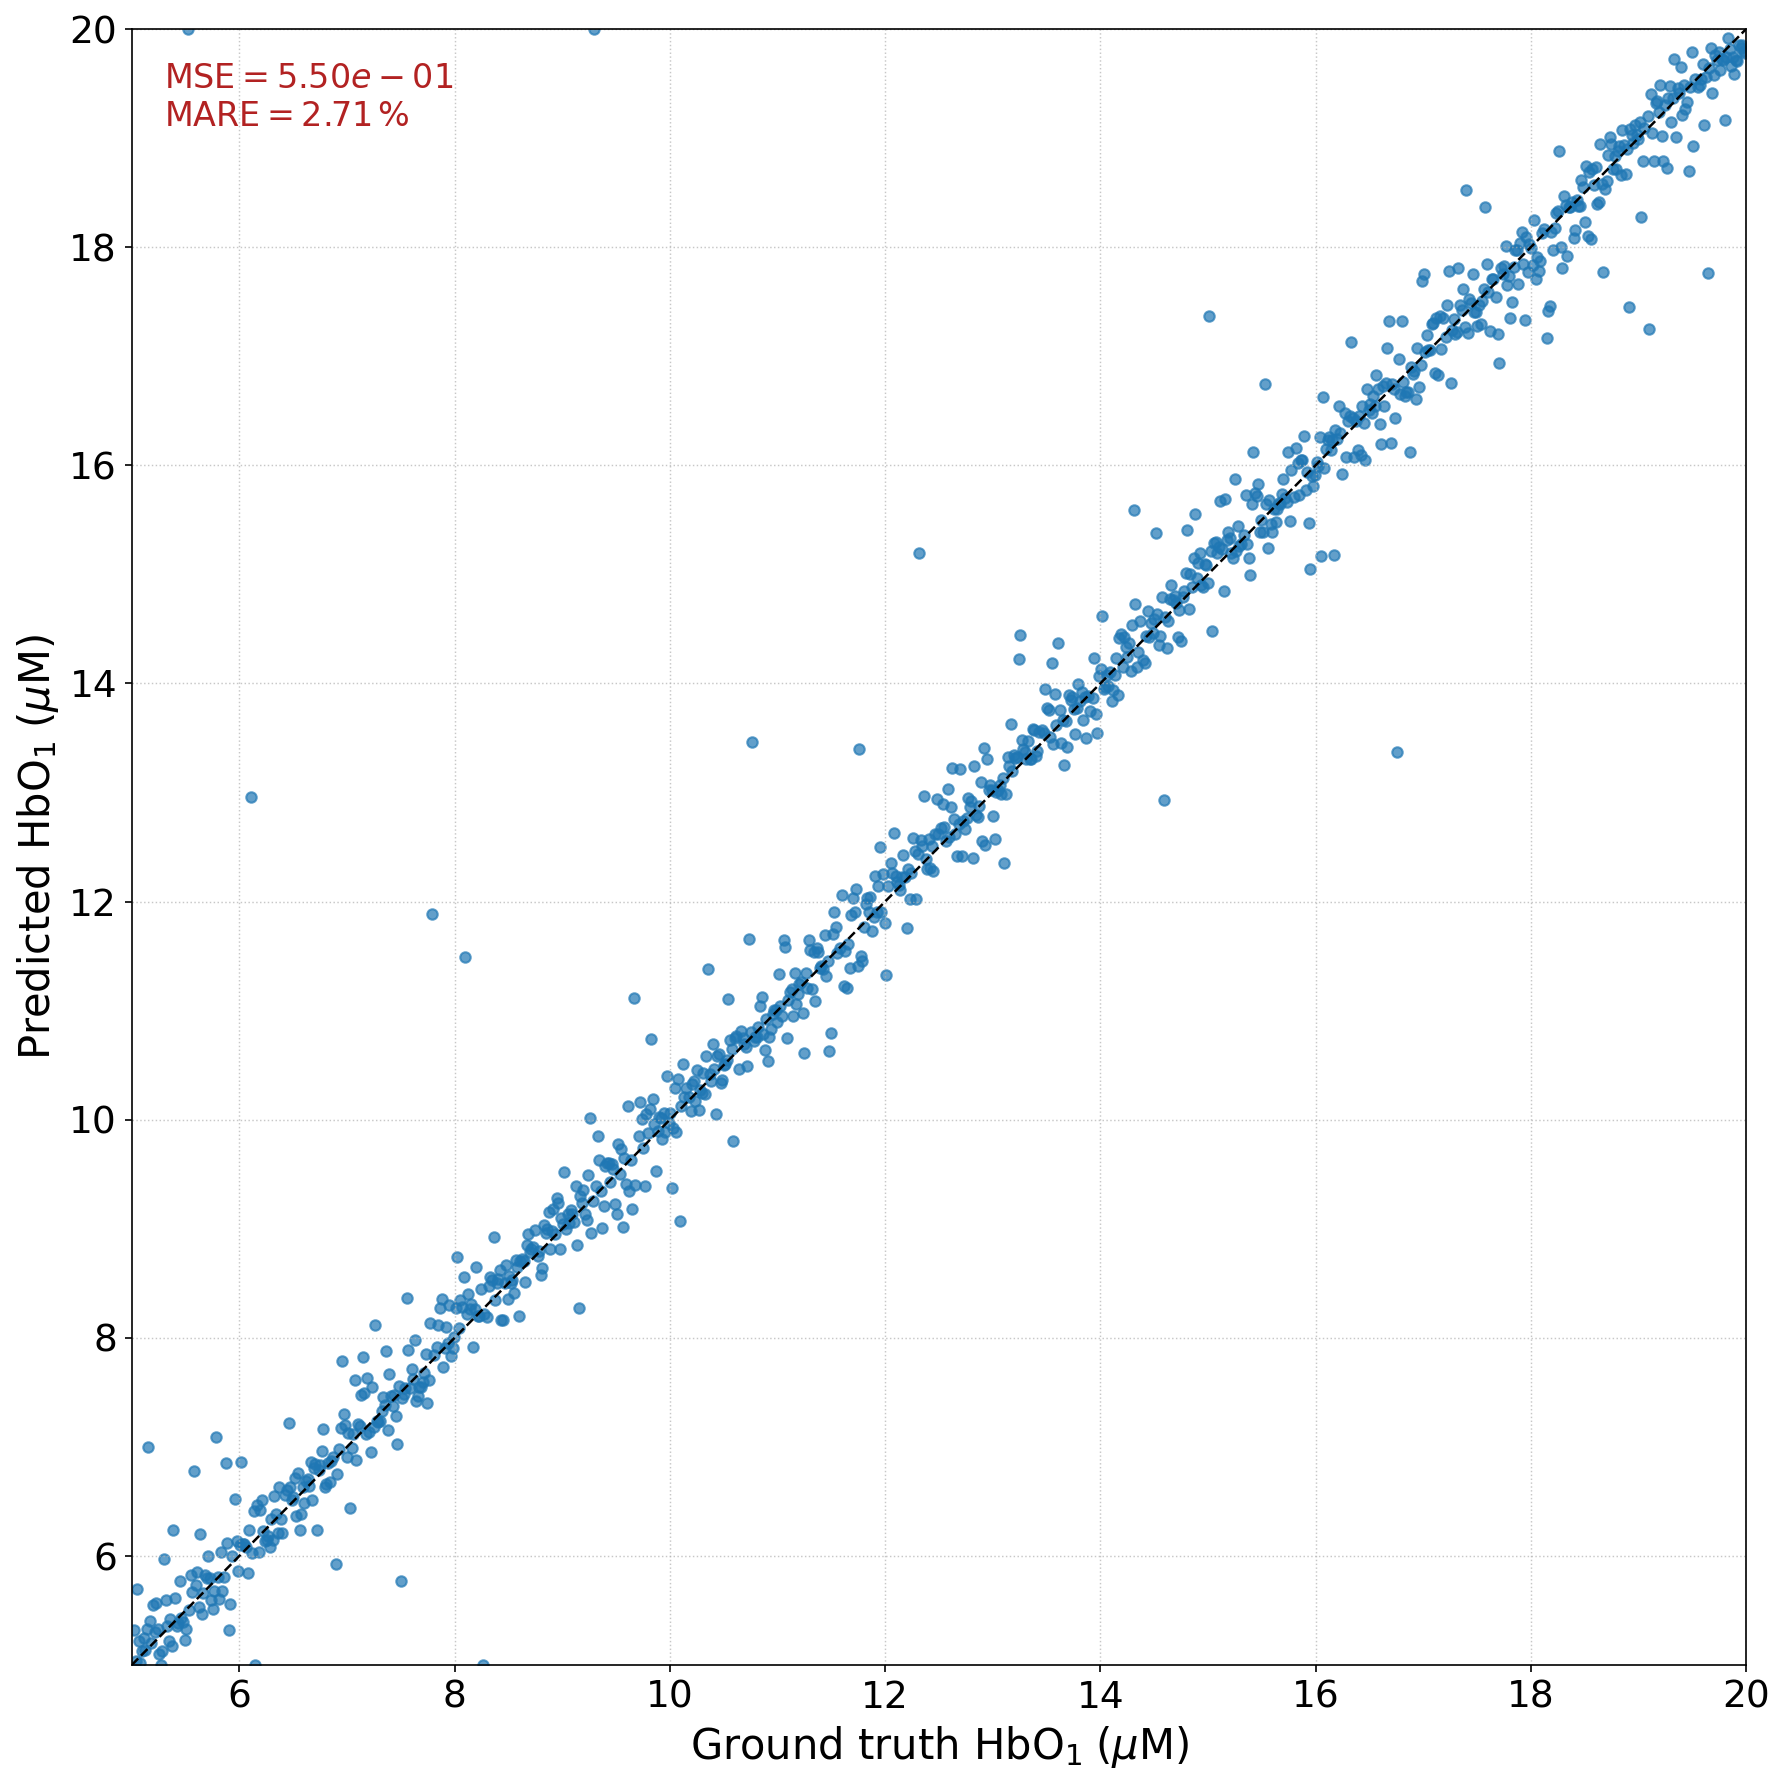

In [12]:
plot_pred_vs_true(
    y_test, y_pred,
    x_label=r"$\mathrm{Ground\ truth\ HbO}_{1}\;(\mu\mathrm{M})$",
    y_label=r"$\mathrm{Predicted\ HbO}_{1}\;(\mu\mathrm{M})$"
)
plt.show()

### HBO2

In [13]:
target = 'HBO2'
starget = 'hbo2'
name = 'HbO2'
root = '/content/drive/MyDrive/MCX_data/weights_td/'

In [14]:
test_sorted_ids = [i+1 for i in range(1000)]
GT_folder_test = '/content/drive/MyDrive/MCX_data/test_csv/'
csv_files = glob.glob(os.path.join(GT_folder_test, '*.csv'))
GT_all_test = pd.concat([pd.read_csv(f) for f in csv_files], ignore_index=True)
GT_all_test['ID'] = GT_all_test['ID'].astype(int)
GT_filtered = GT_all_test[GT_all_test['ID'].isin(test_sorted_ids)].copy()
GT_filtered = GT_filtered.set_index('ID').loc[test_sorted_ids].reset_index()
Y_test = GT_filtered[target].values
Y_test = Y_test.reshape(-1, 1)
scaler_y_path = root + f'TD_{starget}_CNN_scaler_y.pkl'
scaler_y = joblib.load(scaler_y_path)
Y_test = scaler_y.transform(Y_test)
#### LOAD MODEL:
resnet_model = tf.keras.models.load_model(f"/content/drive/MyDrive/MCX_data/weights_td/TD_{starget}_CNN.keras")
y_pred = resnet_model.predict(X_test)
y_pred = np.clip(y_pred, scaler_y.transform(np.array([[param_ranges[target][0]]]))[0][0], scaler_y.transform(np.array([[param_ranges[target][1]]]))[0][0])
mse = mean_squared_error(Y_test, y_pred)
y_pred = scaler_y.inverse_transform(y_pred.reshape(-1, 1)).flatten()
y_test = scaler_y.inverse_transform(Y_test.reshape(-1, 1)).flatten()
metrics = regression_metrics(y_test, y_pred, label=starget)
y_pred_HbO2 = y_pred
y_test_HbO2 = y_test

32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step
hbo2 metrics on test set (n = 1000):
  MAE        :  0.8980
  MARE       :  2.22 %
  RMSE       :  1.6096
  R²         :  0.9655
  Bias ± SD  : -0.2499 ±  1.5909


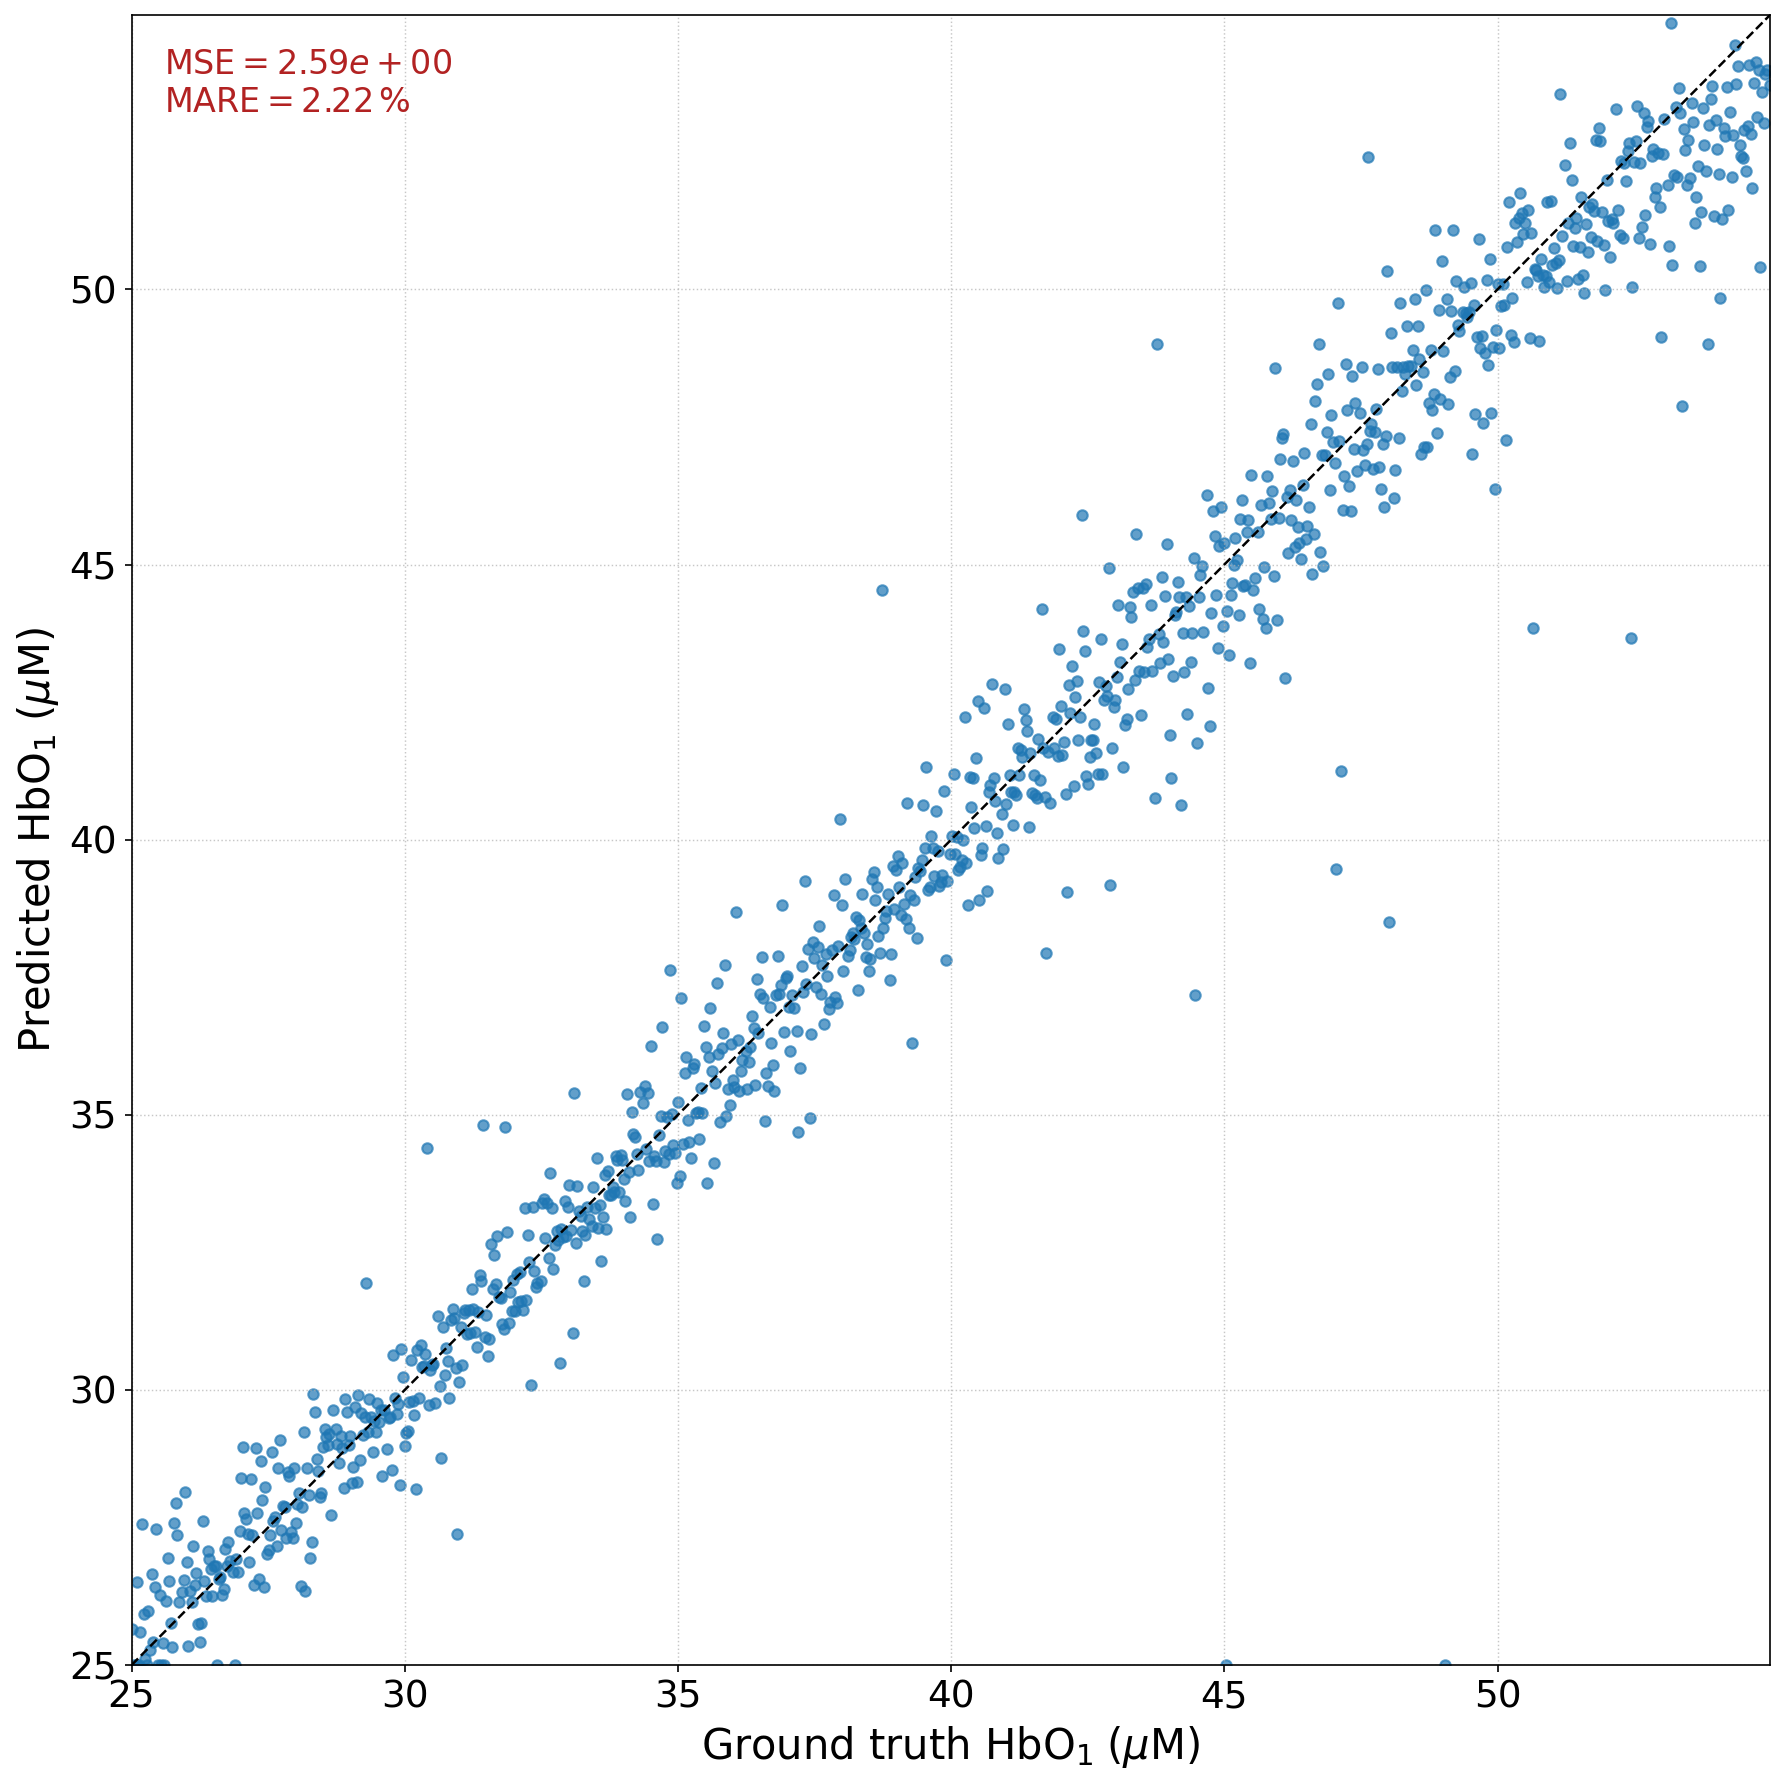

In [15]:
plot_pred_vs_true(
    y_test, y_pred,
    x_label=r"$\mathrm{Ground\ truth\ HbO}_{1}\;(\mu\mathrm{M})$",
    y_label=r"$\mathrm{Predicted\ HbO}_{1}\;(\mu\mathrm{M})$"
)
plt.show()

### Hb2

In [16]:
target = 'HHB2'
starget = 'hhb2'
name = 'Hb2'
root = '/content/drive/MyDrive/MCX_data/weights_td/'

In [17]:
test_sorted_ids = [i+1 for i in range(1000)]
GT_folder_test = '/content/drive/MyDrive/MCX_data/test_csv/'
csv_files = glob.glob(os.path.join(GT_folder_test, '*.csv'))
GT_all_test = pd.concat([pd.read_csv(f) for f in csv_files], ignore_index=True)
GT_all_test['ID'] = GT_all_test['ID'].astype(int)
GT_filtered = GT_all_test[GT_all_test['ID'].isin(test_sorted_ids)].copy()
GT_filtered = GT_filtered.set_index('ID').loc[test_sorted_ids].reset_index()
Y_test = GT_filtered[target].values
Y_test = Y_test.reshape(-1, 1)
#print(np.max(Y_test))
#### scaler:
scaler_y_path = root + f'TD_{starget}_CNN_scaler_y.pkl'
scaler_y = joblib.load(scaler_y_path)
Y_test = scaler_y.transform(Y_test)
print(np.max(Y_test))
#### LOAD MODEL:
resnet_model = tf.keras.models.load_model(f"/content/drive/MyDrive/MCX_data/weights_td/TD_{starget}_CNN.keras")
y_pred = resnet_model.predict(X_test)
y_pred = np.clip(y_pred, scaler_y.transform(np.array([[param_ranges[target][0]]]))[0][0], scaler_y.transform(np.array([[param_ranges[target][1]]]))[0][0])
mse = mean_squared_error(Y_test, y_pred)
y_pred = scaler_y.inverse_transform(y_pred.reshape(-1, 1)).flatten()
y_test = scaler_y.inverse_transform(Y_test.reshape(-1, 1)).flatten()
metrics = regression_metrics(y_test, y_pred, label=starget)
y_pred_Hb2 = y_pred
y_test_Hb2 = y_test

1.7288705044384933
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step
hhb2 metrics on test set (n = 1000):
  MAE        :  0.6375
  MARE       :  2.61 %
  RMSE       :  0.9568
  R²         :  0.9725
  Bias ± SD  : -0.0739 ±  0.9544


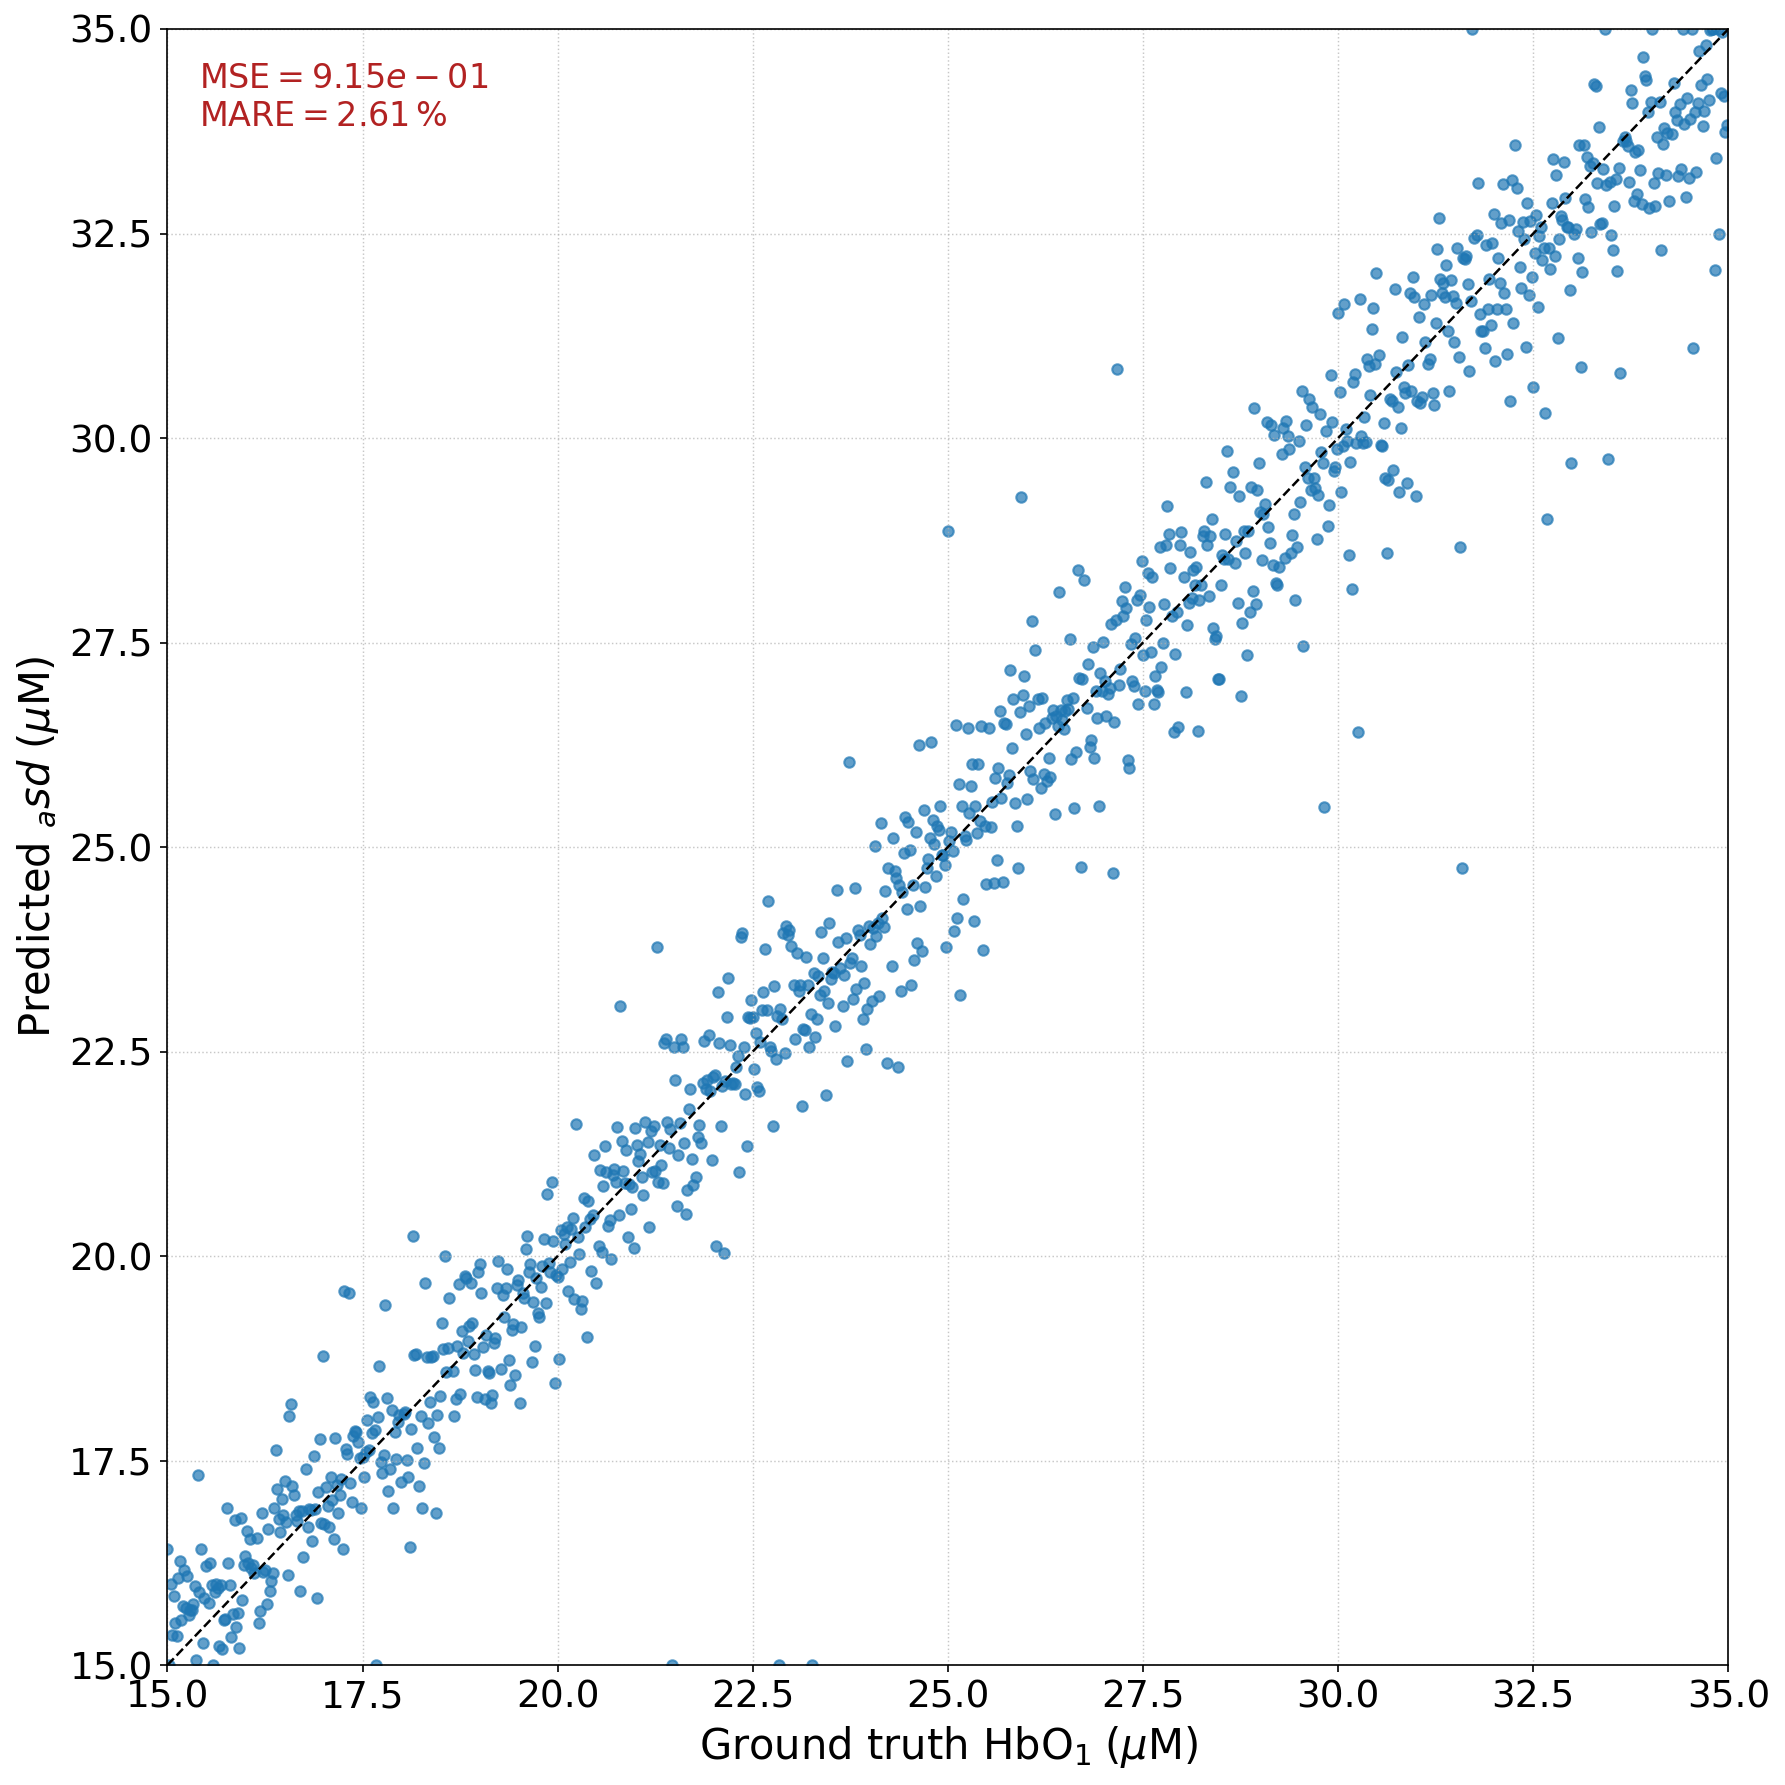

In [18]:
plot_pred_vs_true(
    y_test, y_pred,
    x_label=r"$\mathrm{Ground\ truth\ HbO}_{1}\;(\mu\mathrm{M})$",
    y_label=r"$\mathrm{Predicted\ }_asd\;(\mu\mathrm{M})$"
)
plt.show()

### D1

In [66]:
target = 'd1'
starget = 'thickness'
name = 'd1'
root = '/content/drive/MyDrive/MCX_data/weights_td/'

In [68]:
test_sorted_ids = [i+1 for i in range(1000)]
GT_folder_test = '/content/drive/MyDrive/MCX_data/test_csv/'
csv_files = glob.glob(os.path.join(GT_folder_test, '*.csv'))
GT_all_test = pd.concat([pd.read_csv(f) for f in csv_files], ignore_index=True)
GT_all_test['ID'] = GT_all_test['ID'].astype(int)
GT_filtered = GT_all_test[GT_all_test['ID'].isin(test_sorted_ids)].copy()
GT_filtered = GT_filtered.set_index('ID').loc[test_sorted_ids].reset_index()
Y_test = GT_filtered[target].values
Y_test = Y_test.reshape(-1, 1)
#print(np.max(Y_test))
#### scaler:
scaler_y_path = root + f'TD_{starget}_CNN_scaler_y.pkl'
scaler_y = joblib.load(scaler_y_path)
Y_test = scaler_y.transform(Y_test)
print(np.max(Y_test))
#### LOAD MODEL:
resnet_model = tf.keras.models.load_model(f"/content/drive/MyDrive/MCX_data/weights_td/TD_{target}_CNN.keras")
y_pred = resnet_model.predict(X_test)
y_pred = np.clip(y_pred, scaler_y.transform(np.array([[param_ranges[target][0]]]))[0][0], scaler_y.transform(np.array([[param_ranges[target][1]]]))[0][0])
mse = mean_squared_error(Y_test, y_pred)
y_pred = scaler_y.inverse_transform(y_pred.reshape(-1, 1)).flatten()
y_test = scaler_y.inverse_transform(Y_test.reshape(-1, 1)).flatten()
metrics = regression_metrics(y_test, y_pred, label=starget)
y_pred_d1 = y_pred
y_test_d1 = y_test

1.7149858514250882
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step
thickness metrics on test set (n = 1000):
  MAE        :  0.1534
  MARE       :  1.02 %
  RMSE       :  0.2634
  R²         :  0.9918
  Bias ± SD  :  0.0062 ±  0.2635


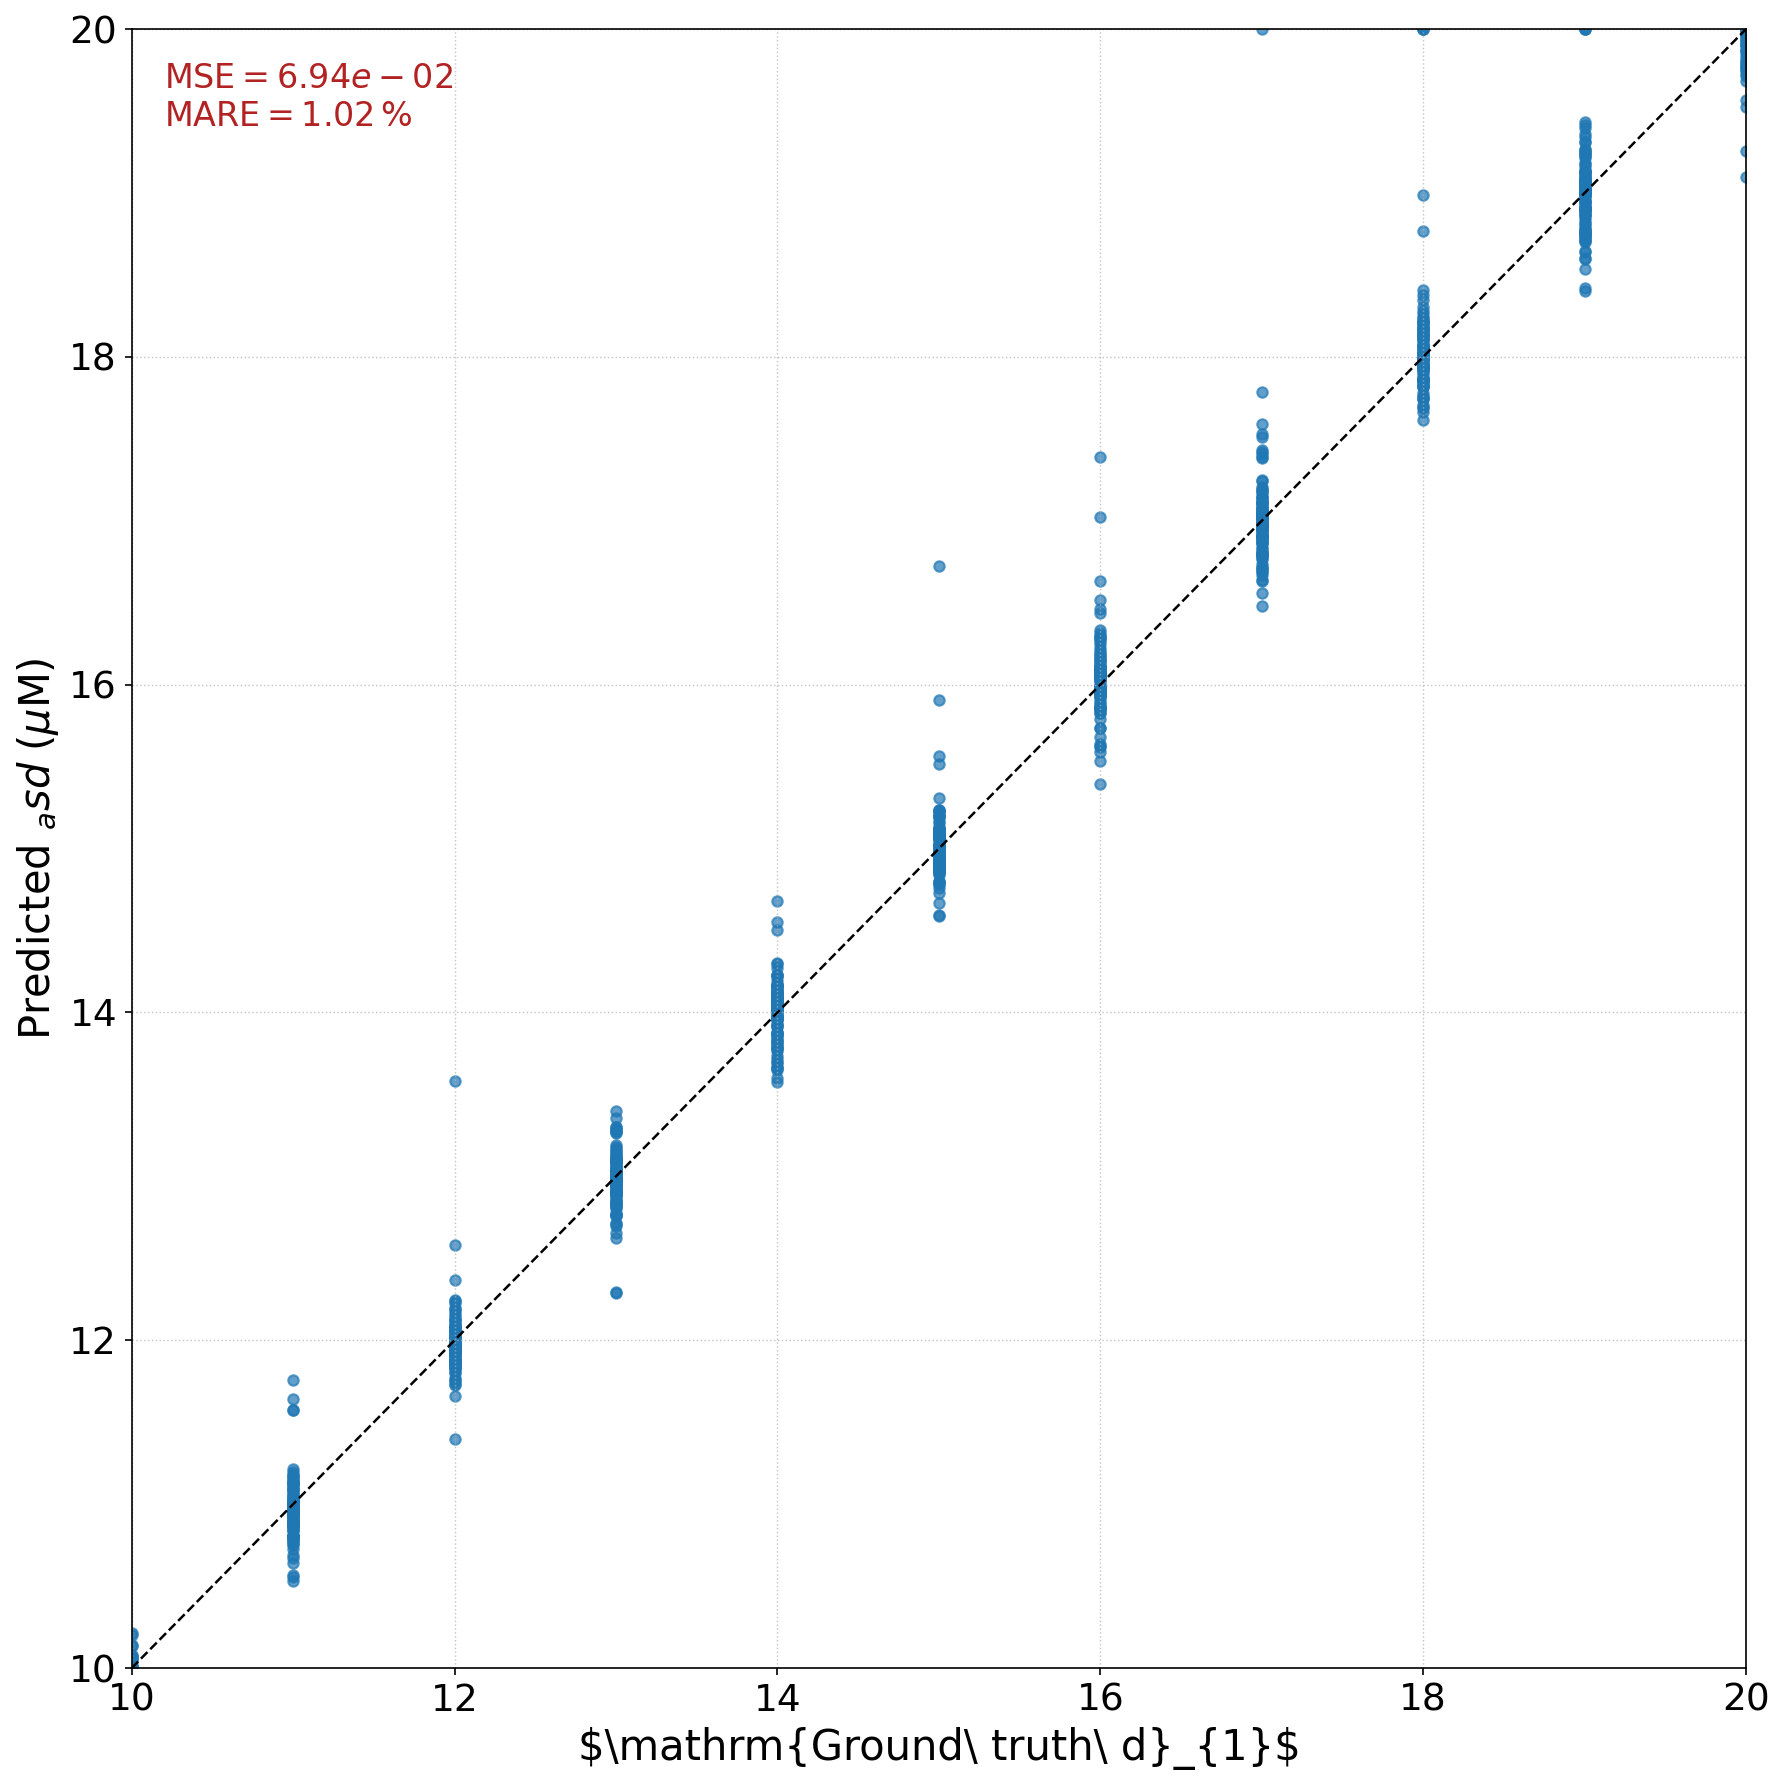

In [71]:
plot_pred_vs_true(
    y_test, y_pred,
    x_label=r"$\mathrm{Ground\ truth\ d}_{1}\$",
    y_label=r"$\mathrm{Predicted\ }_asd\;(\mu\mathrm{M})$"
)
plt.show()

### Hb1

In [19]:
target = 'HHB1'
starget = 'hhb1'
name = 'Hb1'
root = '/content/drive/MyDrive/MCX_data/weights_td/'

In [20]:
test_sorted_ids = [i+1 for i in range(1000)]
GT_folder_test = '/content/drive/MyDrive/MCX_data/test_csv/'
csv_files = glob.glob(os.path.join(GT_folder_test, '*.csv'))
GT_all_test = pd.concat([pd.read_csv(f) for f in csv_files], ignore_index=True)
GT_all_test['ID'] = GT_all_test['ID'].astype(int)
GT_filtered = GT_all_test[GT_all_test['ID'].isin(test_sorted_ids)].copy()
GT_filtered = GT_filtered.set_index('ID').loc[test_sorted_ids].reset_index()
Y_test = GT_filtered[target].values
Y_test = Y_test.reshape(-1, 1)
#print(np.max(Y_test))
#### scaler:
scaler_y_path = root + f'TD_{starget}_CNN_scaler_y.pkl'
scaler_y = joblib.load(scaler_y_path)
Y_test = scaler_y.transform(Y_test)
print(np.max(Y_test))
#### LOAD MODEL:
resnet_model = tf.keras.models.load_model(f"/content/drive/MyDrive/MCX_data/weights_td/TD_{starget}_CNN.keras")
y_pred = resnet_model.predict(X_test)
y_pred = np.clip(y_pred, scaler_y.transform(np.array([[param_ranges[target][0]]]))[0][0], scaler_y.transform(np.array([[param_ranges[target][1]]]))[0][0])
mse = mean_squared_error(Y_test, y_pred)
y_pred = scaler_y.inverse_transform(y_pred.reshape(-1, 1)).flatten()
y_test = scaler_y.inverse_transform(Y_test.reshape(-1, 1)).flatten()
metrics = regression_metrics(y_test, y_pred, label=starget)
y_pred_Hb1 = y_pred
y_test_Hb1 = y_test

1.7304158301672272
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step
hhb1 metrics on test set (n = 1000):
  MAE        :  0.2745
  MARE       :  4.70 %
  RMSE       :  0.6137
  R²         :  0.9548
  Bias ± SD  :  0.0142 ±  0.6139


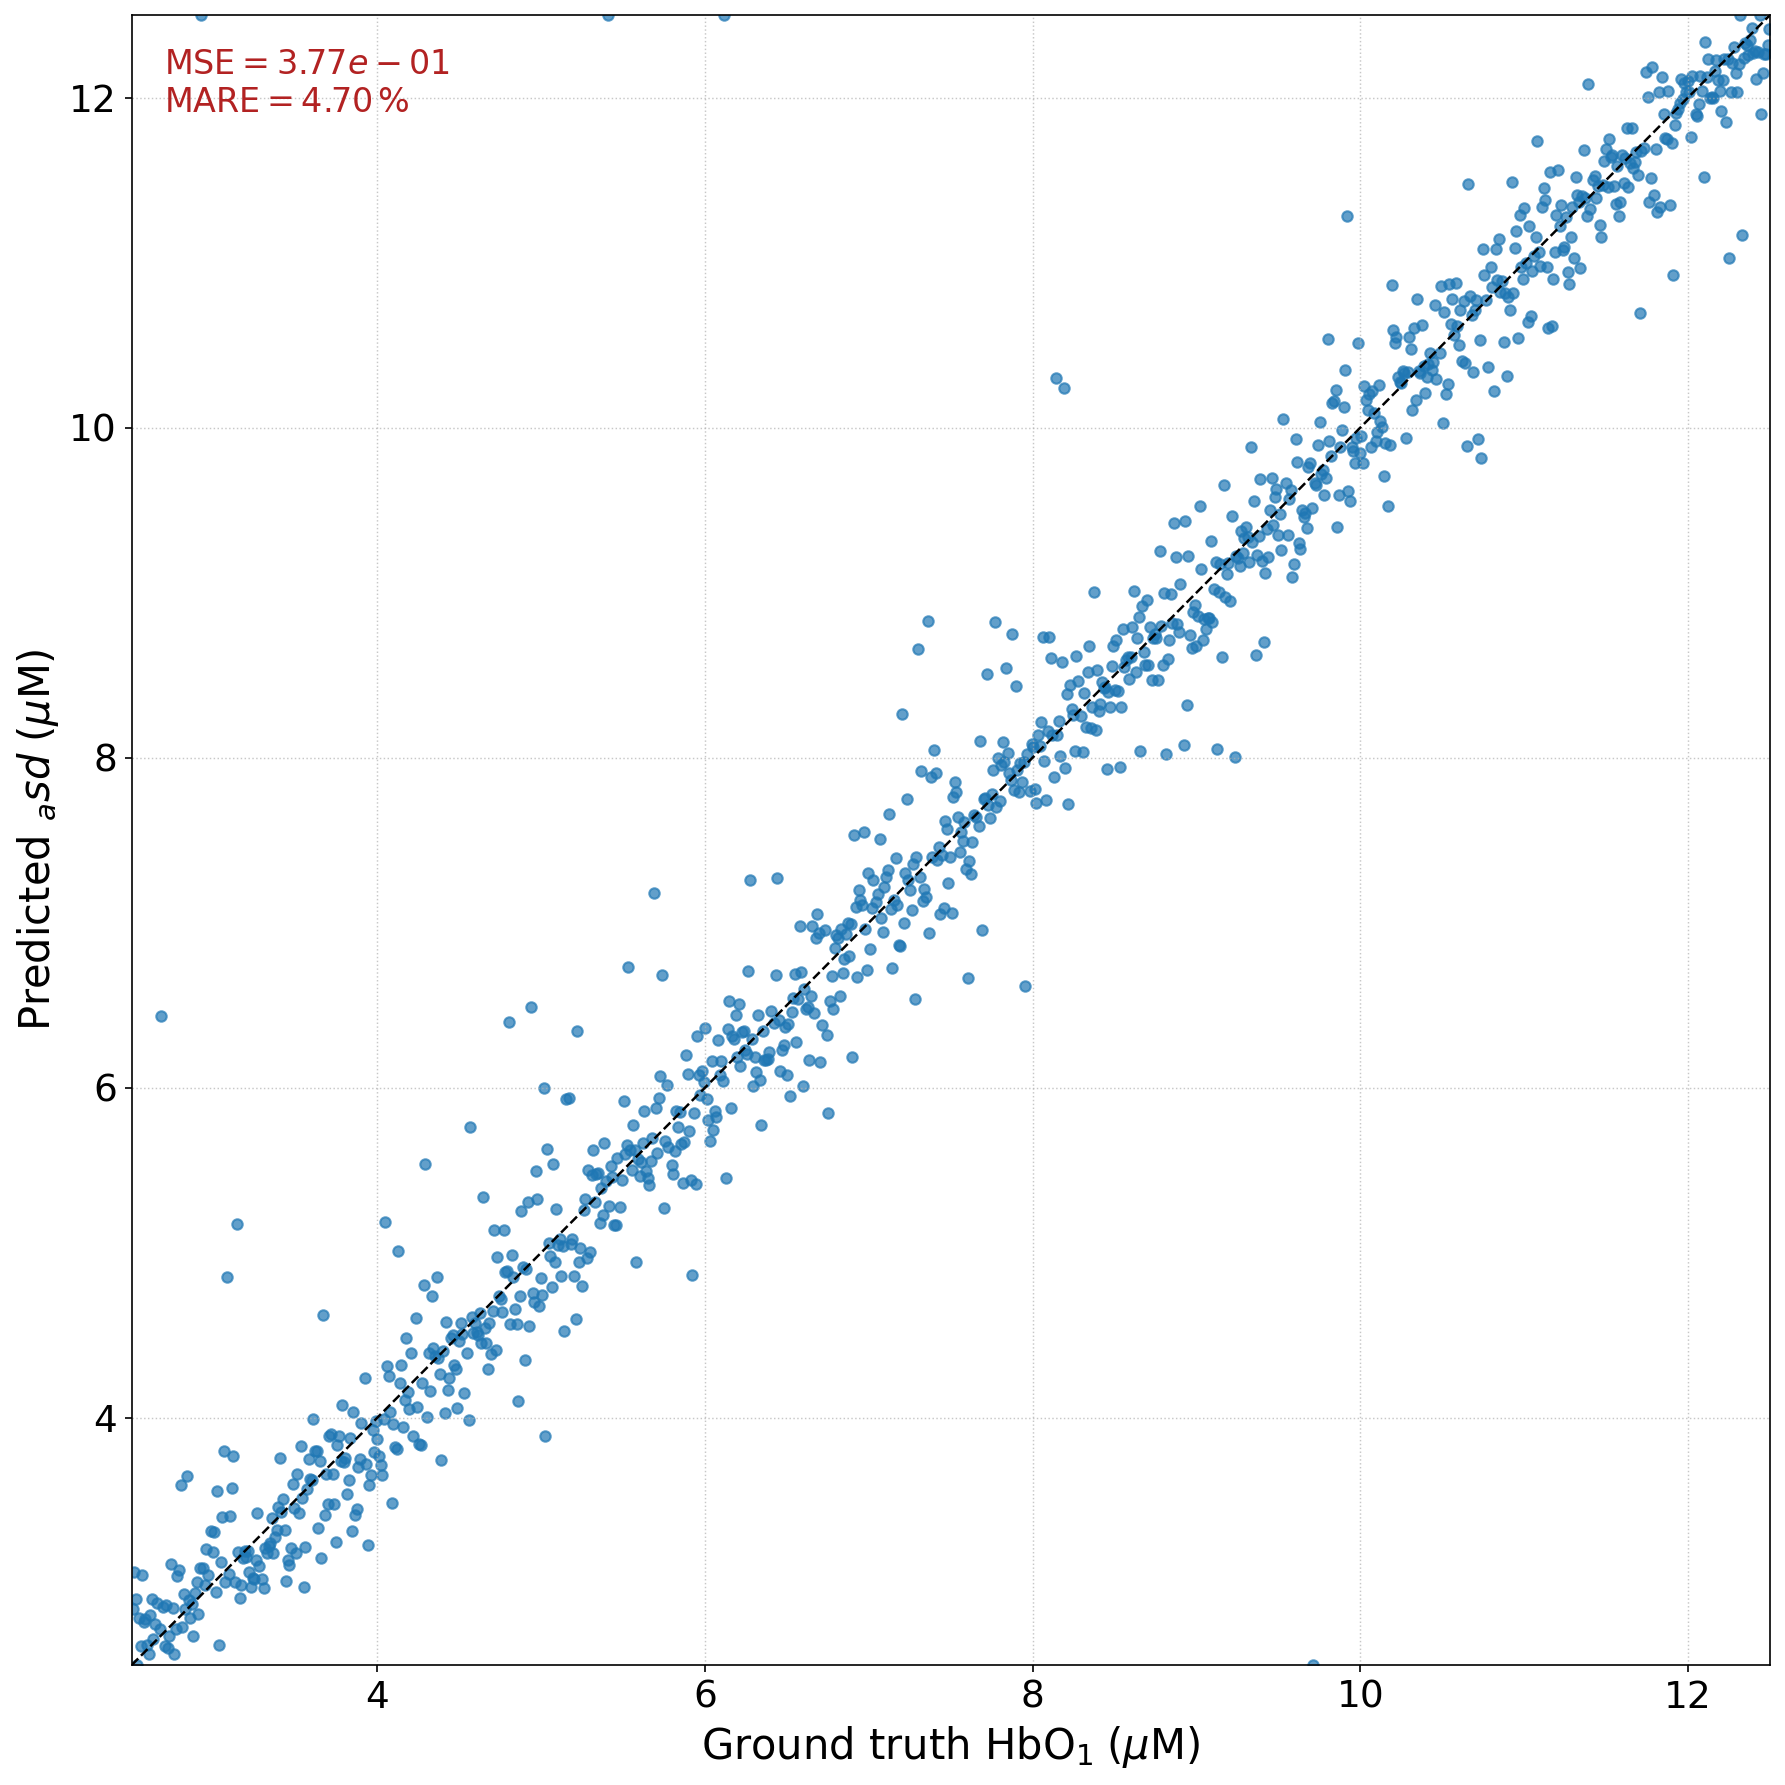

In [21]:
plot_pred_vs_true(
    y_test, y_pred,
    x_label=r"$\mathrm{Ground\ truth\ HbO}_{1}\;(\mu\mathrm{M})$",
    y_label=r"$\mathrm{Predicted\ }_asd\;(\mu\mathrm{M})$"
)
plt.show()

### PlotingS

/tmp/ipython-input-62-4113864425.py:109: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


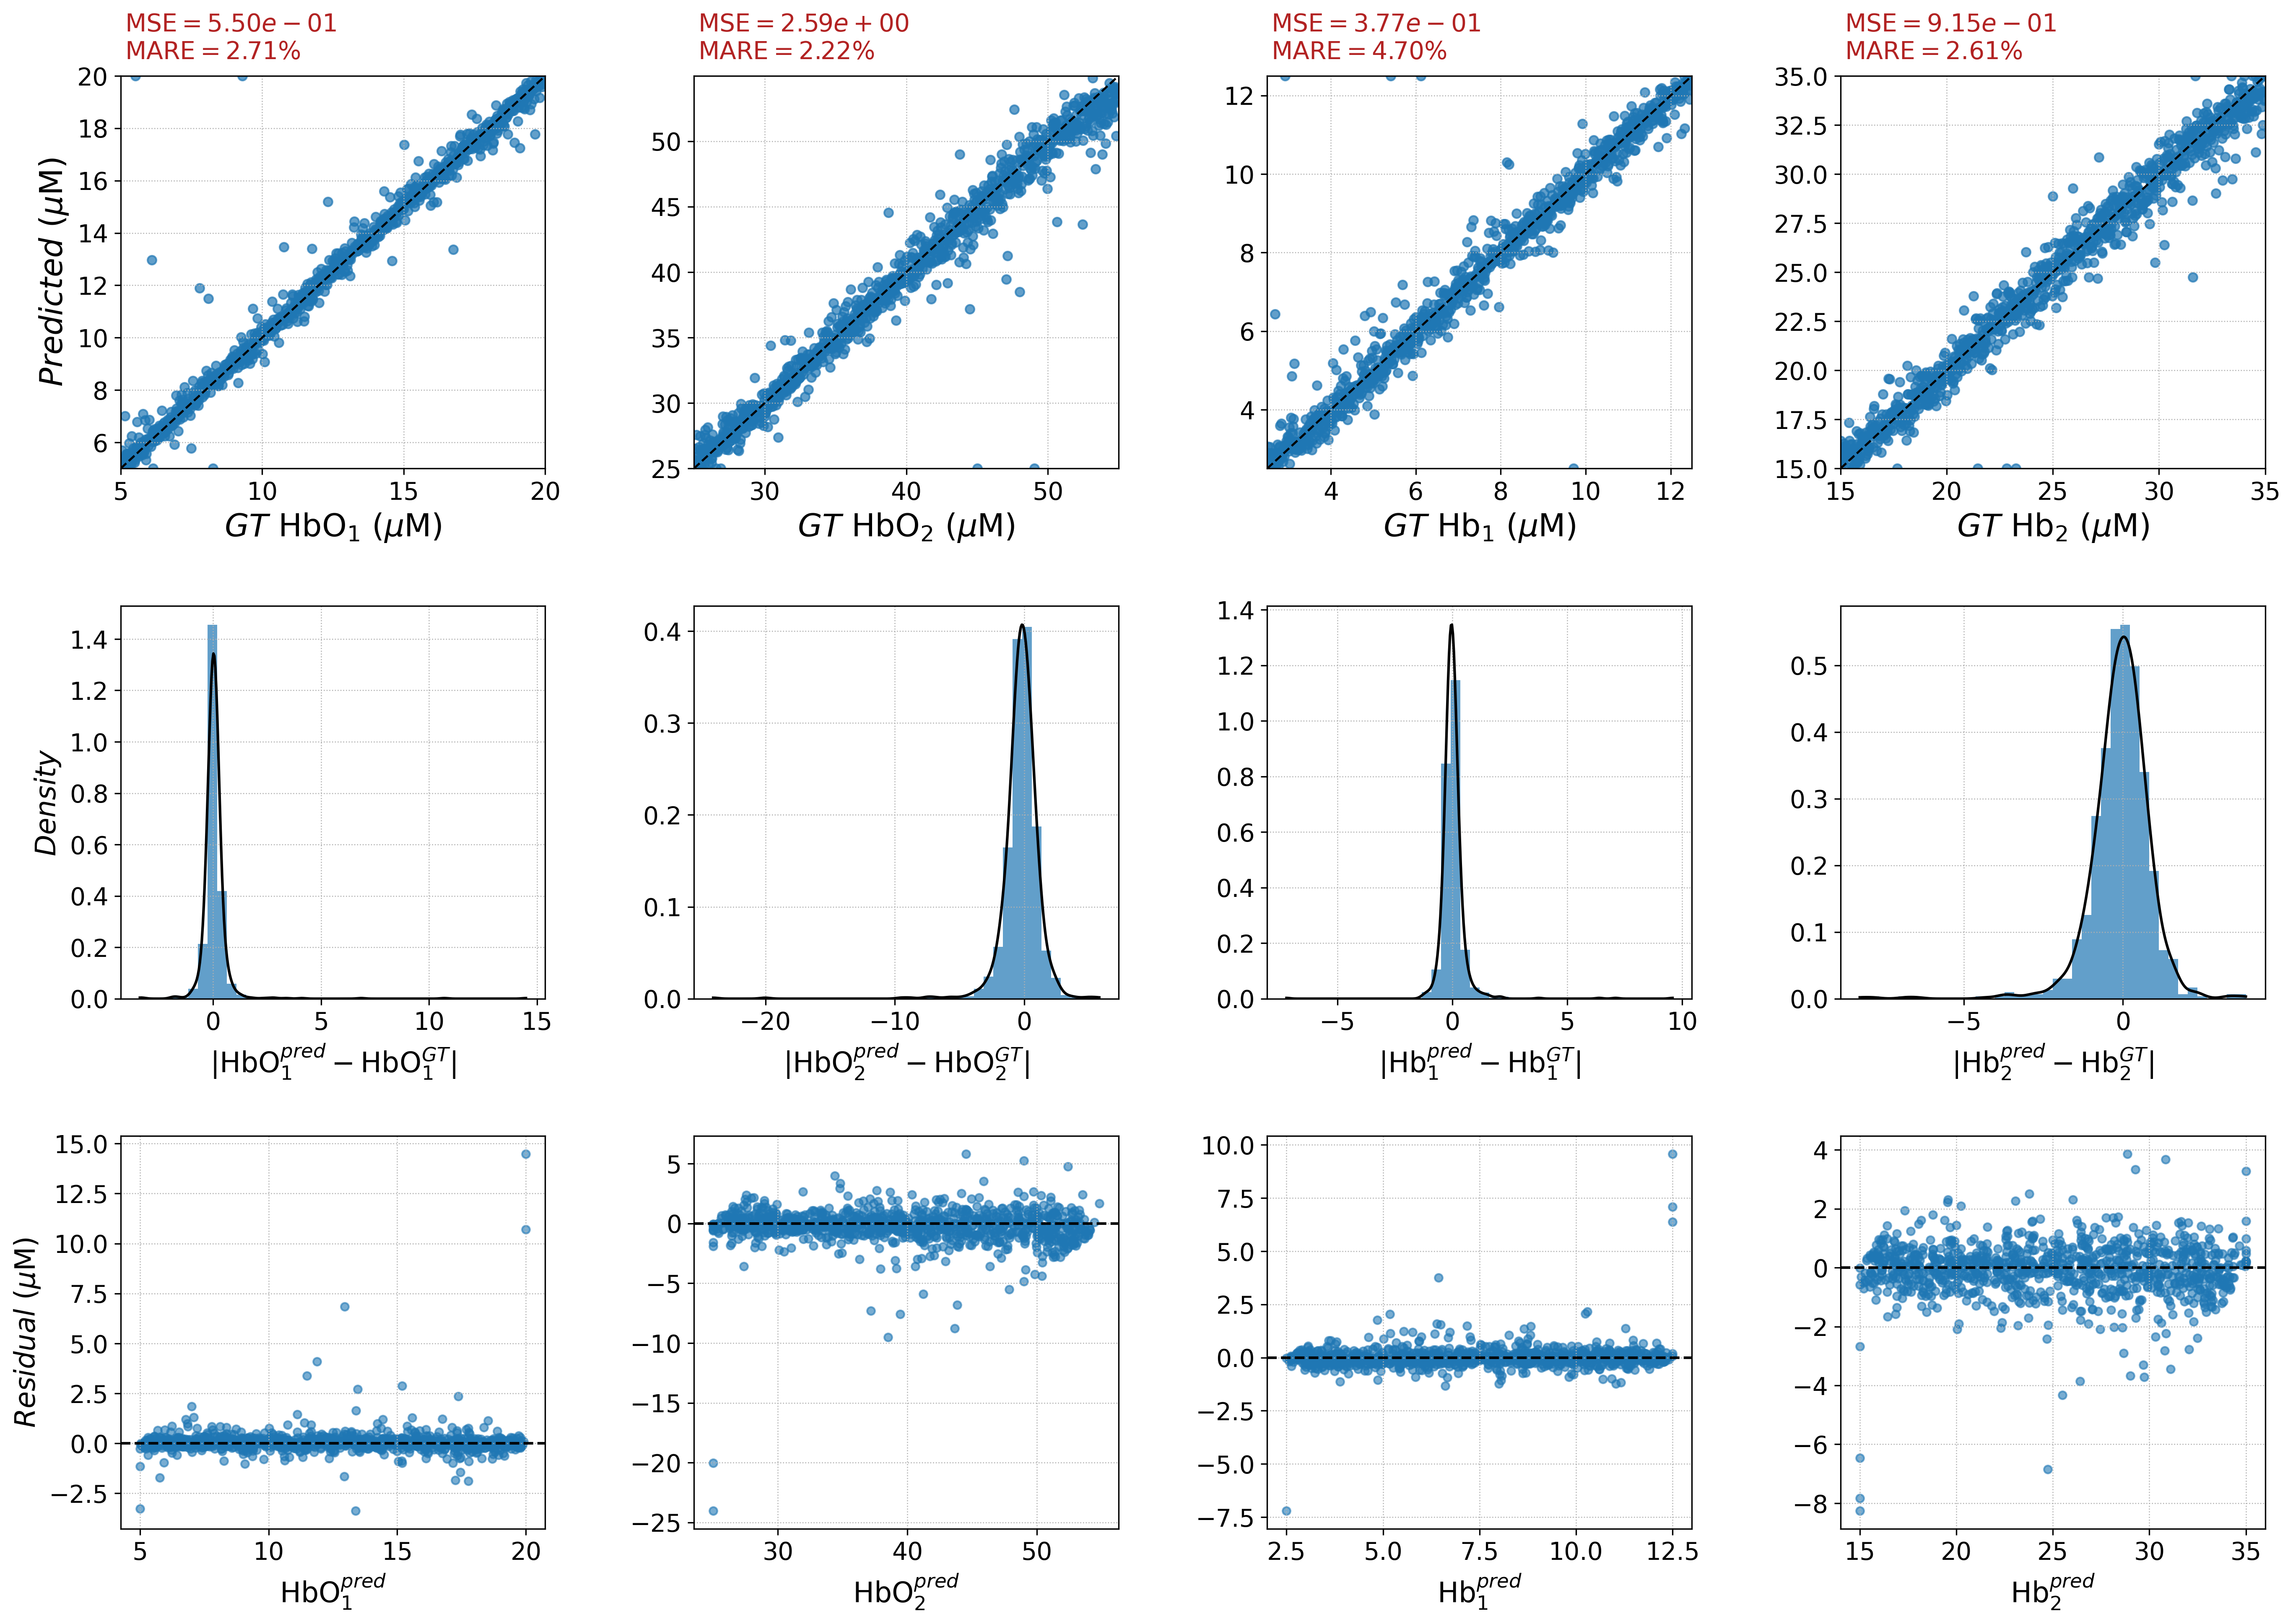

In [63]:
names   = [r"\mathrm{HbO}_{1}", r"\mathrm{HbO}_{2}", r"\mathrm{Hb}_{1}",  r"\mathrm{Hb}_{2}"]

fig = plot_3x4_suite(
        [y_test_HbO1, y_test_HbO2, y_test_Hb1, y_test_Hb2],
        [y_pred_HbO1, y_pred_HbO2, y_pred_Hb1, y_pred_Hb2],
        names,
        units=r"\mu\mathrm{M}",
)
fig.savefig("NIRS_8panel.png", dpi=600, bbox_inches="tight")
plt.show()

In [41]:
names = ["HbO₁", "HbO₂", "Hb₁", "Hb₂"]
df_metrics = metrics_table(
    [y_test_HbO1, y_test_HbO2, y_test_Hb1, y_test_Hb2],
    [y_pred_HbO1, y_pred_HbO2, y_pred_Hb1, y_pred_Hb2],
    names
)

df_metrics.to_csv("metrics.csv", index=False)
print(df_metrics.to_latex(index=False, float_format="%.3f"))

Parameters   MAE  MARE (%)  RMSE  $R^{2}$      Bias ± SD
      HbO₁ 0.269     2.712 0.742    0.971  0.071 ± 0.739
      HbO₂ 0.898     2.218 1.610    0.965 -0.250 ± 1.591
       Hb₁ 0.275     4.701 0.614    0.955  0.014 ± 0.614
       Hb₂ 0.638     2.614 0.957    0.973 -0.074 ± 0.954
\begin{tabular}{lrrrrl}
\toprule
Parameters & MAE & MARE (%) & RMSE & $R^{2}$ & Bias ± SD \\
\midrule
HbO₁ & 0.269 & 2.712 & 0.742 & 0.971 & 0.071 ± 0.739 \\
HbO₂ & 0.898 & 2.218 & 1.610 & 0.965 & -0.250 ± 1.591 \\
Hb₁ & 0.275 & 4.701 & 0.614 & 0.955 & 0.014 ± 0.614 \\
Hb₂ & 0.638 & 2.614 & 0.957 & 0.973 & -0.074 ± 0.954 \\
\bottomrule
\end{tabular}



/tmp/ipython-input-87-2529320246.py:73: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


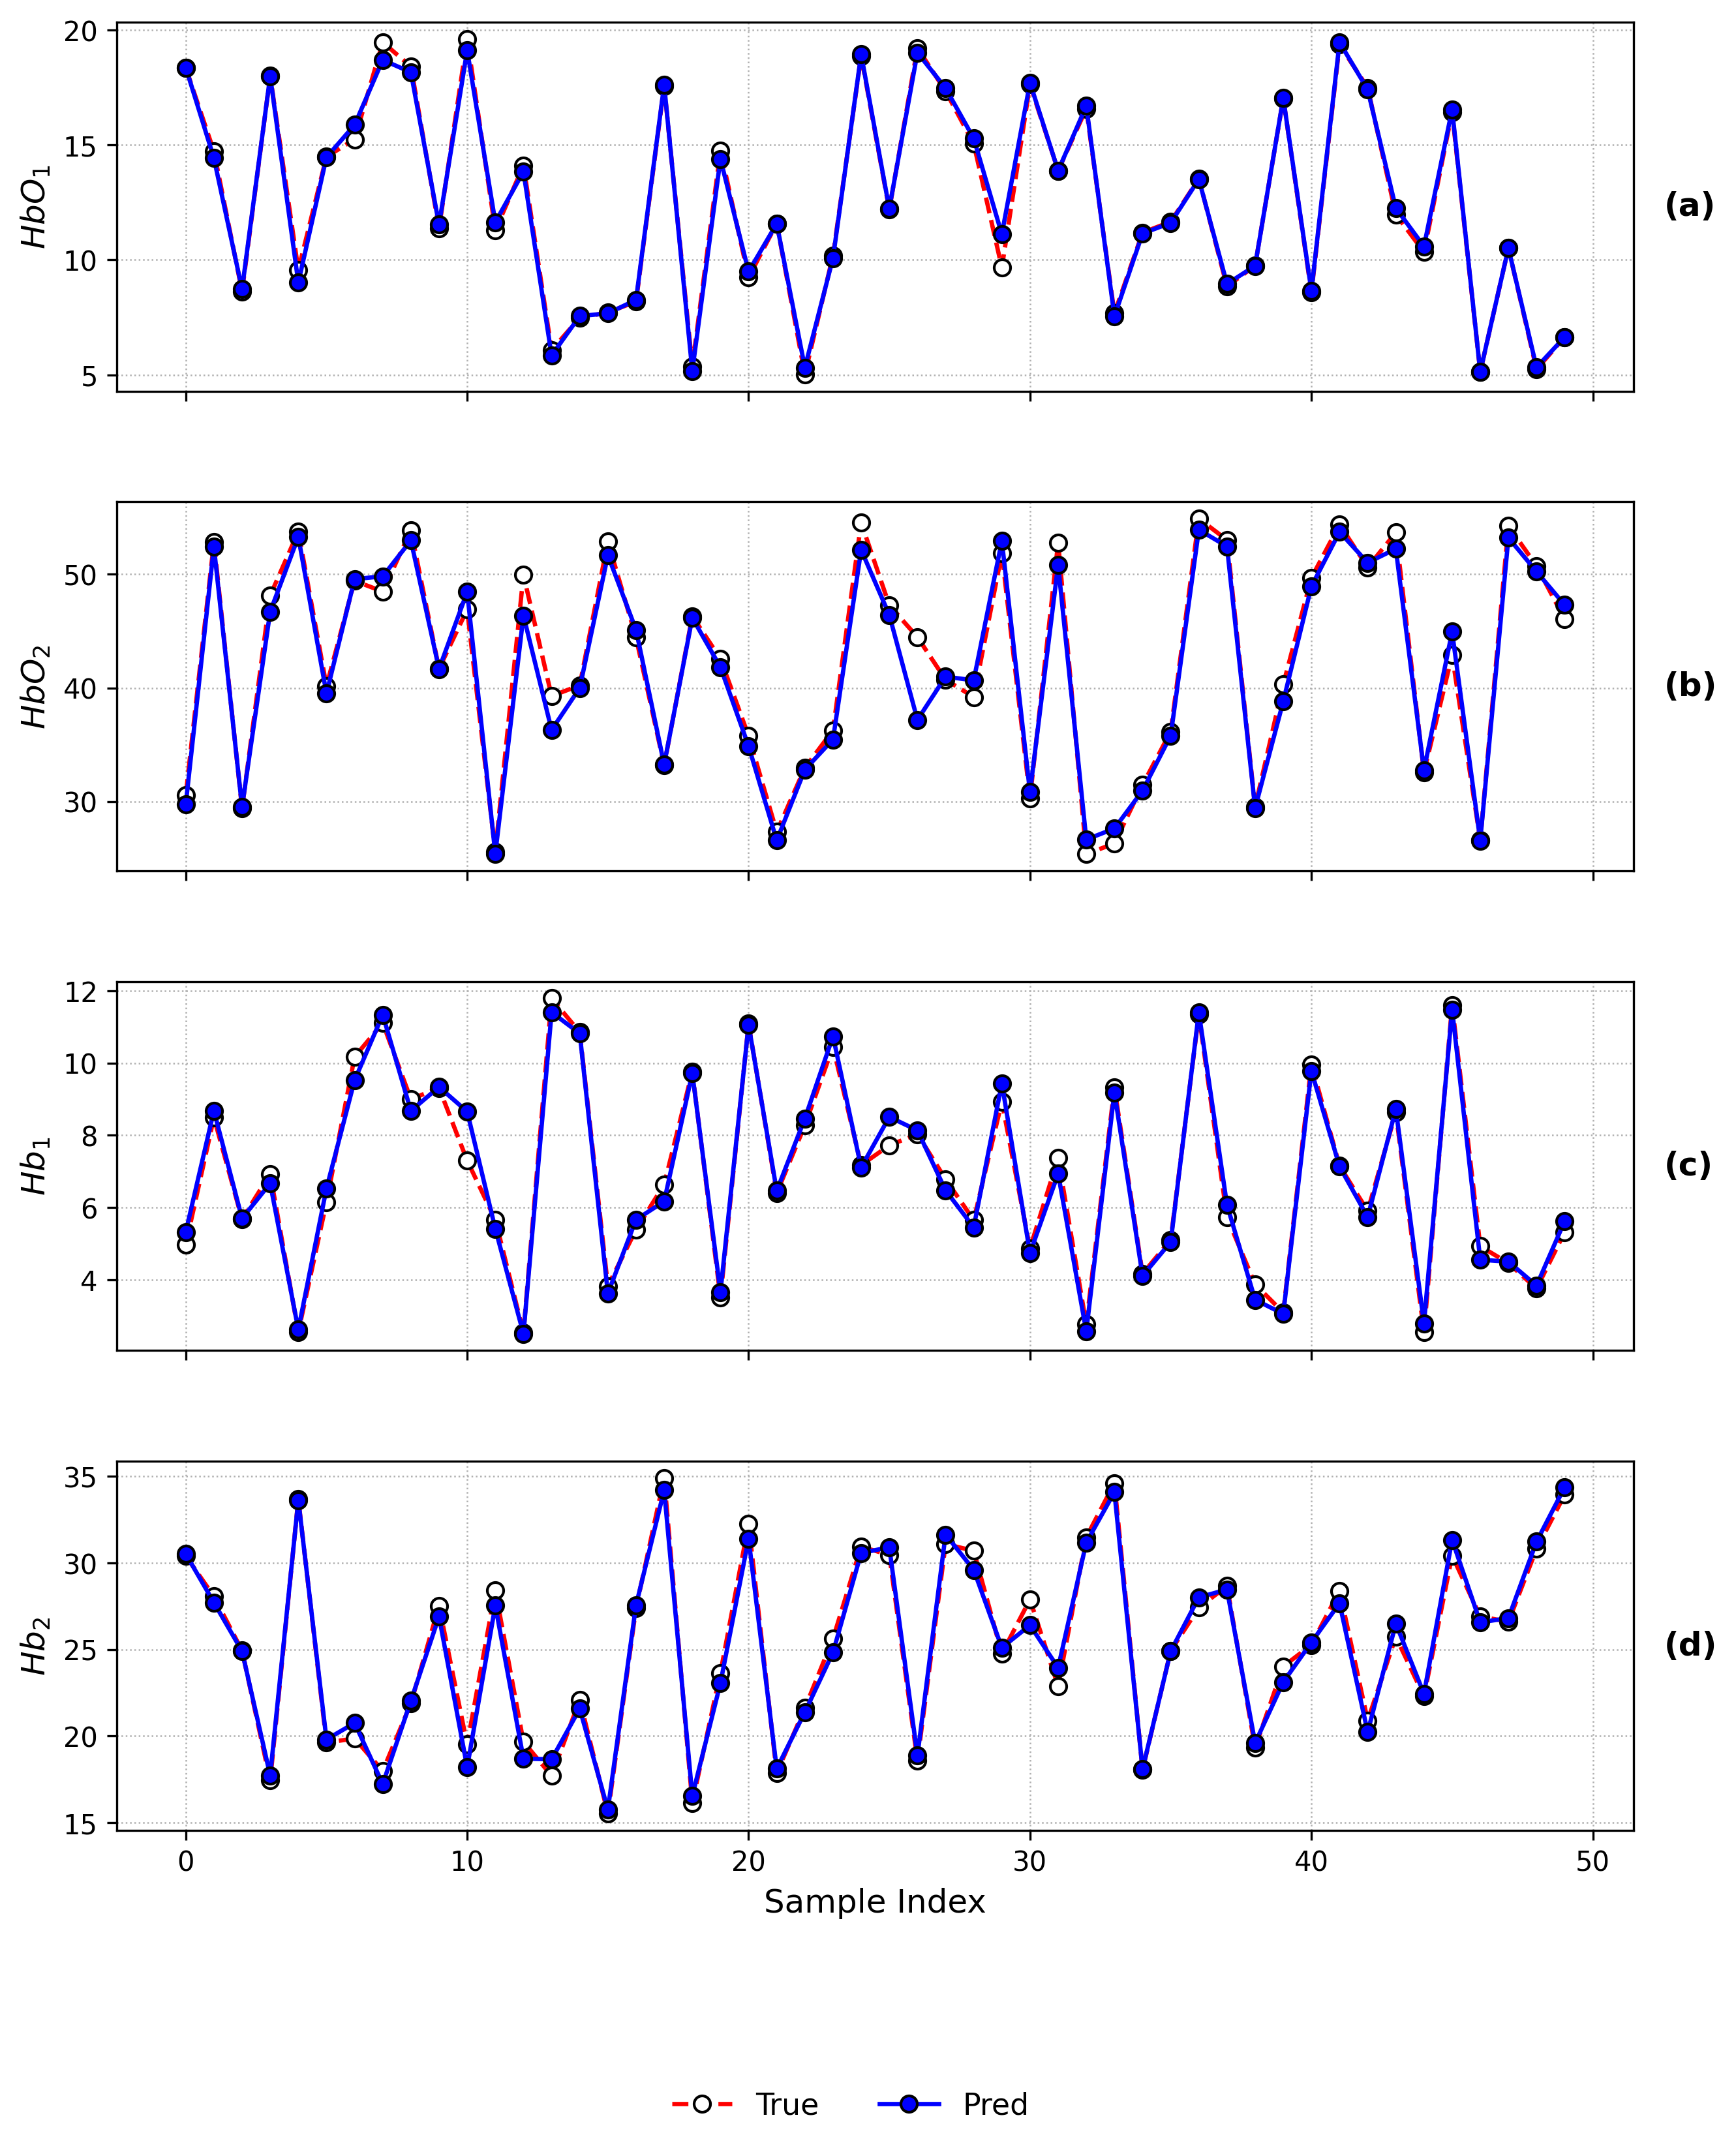

In [88]:
fig = plot_random_sequences(
        y_trues=[y_test_HbO1, y_test_HbO2, y_test_Hb1, y_test_Hb2],
        y_preds=[y_pred_HbO1, y_pred_HbO2, y_pred_Hb1, y_pred_Hb2],
        names=[r"HbO_{1}", r"HbO_{2}", r"Hb_{1}", r"Hb_{2}"],
        n_samples=50,
        random_state=42
)

fig.savefig("random_stacked_four.png", dpi=600, bbox_inches="tight")
plt.show()
